# RNN  

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import pandas as pd
from sklearn.metrics import accuracy_score
import time

## NEW PART ADDED !!

### collate_fn is a function that tells DataLoader how to combine a list of samples to a batch.

In [21]:
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.tensor(labels)
    return padded_sequences, lengths, labels



In [22]:
D = 28*28
n = 256
C = 1

classes = 10

model_regular = nn.Sequential(
    nn.Flatten(), 
    nn.Linear(D, n), 
    nn.Tanh(), 
    nn.Linear(n, n),
    nn.Tanh(),
    nn.Linear(n, n), 
    nn.Tanh(), 
    nn.Linear(n, classes), 
)

In [23]:
h_2 = nn.Linear(n, n)

model_shared = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D, n), 
    nn.Tanh(), h_2,
    nn.Tanh(), h_2,
    nn.Tanh(),
    nn.Linear(n, classes),
)

# Lets build an RNN network 

In [24]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [25]:
namge_language_data = {}

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i
    
# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file. 
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too. 


Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [26]:
namge_language_data.keys()

dict_keys(['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese'])

In [27]:
# Show the first 10 Arabic names in the dataset
print("First 10 Arabic names in the dataset:")
for i, name in enumerate(namge_language_data["Arabic"][:10], 1):
    print(f"{i}. {name}")

First 10 Arabic names in the dataset:
1. khoury
2. nahas
3. daher
4. gerges
5. nazari
6. maalouf
7. gerges
8. naifeh
9. guirguis
10. baba


In [28]:
class LanguageNameDataset(Dataset):
    '''
    self.label_names becomes ['English', 'Spanish', 'Japanese']
    self.data becomes ['Smith', 'Johnson', 'Williams', 'Garcia', 'Rodriguez', 'Lopez', 'Tanaka', 'Suzuki', 'Sato']
    self.labels becomes [0, 0, 0, 1, 1, 1, 2, 2, 2] (0 for English, 1 for Spanish, 2 for Japanese)

    Now, let's see what happens when we access a specific item, for example dataset[4]:

    The __getitem__ method is called with idx=4
    It retrieves name = self.data[4] which is 'Rodriguez'
    It retrieves label = self.labels[4] which is 1 (Spanish)
    It calls self.string2InputVec('Rodriguez') which does the following:

    Creates a tensor of zeros with length 9 (number of characters in "Rodriguez")
    For each character, it replaces the zeros with the corresponding integer from the vocabulary:

    'R' → 44
    'o' → 15
    'd' → 4
    'r' → 18
    'i' → 9
    'g' → 7
    'u' → 21
    'e' → 5
    'z' → 26


    This creates the tensor: tensor([44, 15, 4, 18, 9, 7, 21, 5, 26])


    It converts the label 1 to a tensor: tensor([1])
    It returns the tuple: (tensor([44, 15, 4, 18, 9, 7, 21, 5, 26]), tensor([1]))
    '''
    
    def __init__(self, lang_name_dict, vocabulary):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.vocabulary = vocabulary
        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                self.data.append(sample)
                self.labels.append(y)
        
    def __len__(self):
        return len(self.data)
    
    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object. 
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?
        
        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]
            
        return name_vec
    
    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]
        
        # Convert the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)
        
        return self.string2InputVec(name), label


## NEW MODIFICATION ADDED !!
## by calling the collate_fn=collate_fn inside the dataloader.

In [29]:
dataset = LanguageNameDataset(namge_language_data, alphabet)
## i need to change the batch size
train_data, test_data = torch.utils.data.random_split(dataset, (len(dataset)-300, 300))
train_loader = DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False, collate_fn=collate_fn)

In [30]:
# example of embedding
# ammae
'input sequence with T = 5 items but a vocabulary of only 3 items'
with torch.no_grad():
    input_sequence = torch.tensor([0, 1, 1, 0, 2], dtype=torch.long)
    embd = nn.Embedding(3, 2)
    x_seq = embd(input_sequence)
    print(input_sequence.shape, x_seq.shape)
    print(x_seq)

torch.Size([5]) torch.Size([5, 2])
tensor([[ 0.2893,  0.1752],
        [ 0.9180,  1.7443],
        [ 0.9180,  1.7443],
        [ 0.2893,  0.1752],
        [ 0.3958, -1.5579]])


In [31]:
class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step following 
    the output of a PyTorch RNN module. 
    it extracts the final hidden state from the RNN, 
    which contains the model's "understanding" of the entire name sequence
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_driections = 2
        else:
            self.num_driections = 1    
    
    def forward(self, input):
        #Result is either a tuple (out, h_t)
        #or a tuple (out, (h_t, c_t))
        rnn_output = input[0]
        last_step = input[1] #this will be h_t
        if(type(last_step) == tuple): # unless it's a tuple, 
            last_step = last_step[0] # then h_t is the first item in the tuple
        batch_size = last_step.shape[1] # per docs, shape is: '(num_layers * num_directions, batch, hidden_size)'
        # reshaping so that everything is separate 
        last_step = last_step.view(self.rnn_layers, self.num_driections, batch_size, -1)
        # We want the last layer's results
        last_step = last_step[self.rnn_layers-1] 
        # Re order so batch comes first
        last_step = last_step.permute(1, 0, 2)
        # Finally, flatten the last two dimensions into one
        return last_step.reshape(batch_size, -1)



### NEW PART ADDED !!

In [32]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.RNN(emb_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, lengths):
        x = self.embedding(x)
        lengths = lengths.cpu()  # Required for pack_padded_sequence
        x_packed = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        _, hidden = self.rnn(x_packed)
        return self.fc(hidden[-1])  # Final hidden state


In [33]:
D = 64
vocab_size = len(all_letters)
hidden_nodes = 256
classes = len(dataset.label_names)

first_rnn = nn.Sequential(
  nn.Embedding(vocab_size, D), #(B, T) -> (B, T, D)
  nn.RNN(D, hidden_nodes, batch_first=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
  # the tanh activation is built into the RNN object, so we don't need to do it here
  LastTimeStep(), # We need to take the RNN output and reduce it to one item, (B, D)
  nn.Linear(hidden_nodes, classes), #(B, D) -> (B, classes)
)


### PART ADDED TO CALL THE RNN !!

In [34]:
model = RNN(
    vocab_size=len(all_letters),
    emb_dim=64,
    hidden_dim=256,
    output_dim=len(dataset.label_names)
)


### SOME MODIFICATIONS IN THE move_to ,run_epoch

In [35]:
def move_to(x, device):
    if isinstance(x, (list, tuple)):
        return [move_to(elem, device) for elem in x]
    return x.to(device)

    
def run_epoch(dataloader, model, loss_func, optimizer=None, device='cpu', score_funcs={}):
    is_training = optimizer is not None
    model.train() if is_training else model.eval()

    total_loss = 0
    targets, predictions = [], []

    for xb, lengths, yb in dataloader:
        xb, lengths, yb = move_to(xb, device), move_to(lengths, device), move_to(yb, device)

        out = model(xb, lengths)
        loss = loss_func(out, yb)

        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * yb.size(0)
        predictions.extend(out.argmax(dim=1).tolist())
        targets.extend(yb.tolist())

    avg_loss = total_loss / len(dataloader.dataset)
    scores = {name: func(targets, predictions) for name, func in score_funcs.items()}
    return avg_loss, scores


def train_simple_network(model, loss_func, train_loader, test_loader=None, score_funcs={}, device='cpu', epochs=10):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    history = []

    for epoch in range(epochs):
        train_loss, train_scores = run_epoch(train_loader, model, loss_func, optimizer, device, score_funcs)
        result = {'epoch': epoch, 'train loss': train_loss, **{f'train {k}': v for k, v in train_scores.items()}}

        if test_loader:
            test_loss, test_scores = run_epoch(test_loader, model, loss_func, None, device, score_funcs)
            result.update({'test loss': test_loss, **{f'test {k}': v for k, v in test_scores.items()}})

        history.append(result)
        print(result)

    return pd.DataFrame(history)


In [36]:
loss_func = nn.CrossEntropyLoss()
results_df = train_simple_network(
    model,
    loss_func,
    train_loader,
    test_loader=test_loader,
    score_funcs={'Accuracy': accuracy_score},
    device='cpu',  # use 'cuda' or 'mps' if supported
    epochs=5
)


{'epoch': 0, 'train loss': 0.9753313568685683, 'train Accuracy': 0.7125012642864368, 'test loss': 0.71276806751887, 'test Accuracy': 0.7833333333333333}
{'epoch': 1, 'train loss': 0.6777088013037253, 'train Accuracy': 0.7924041670880955, 'test loss': 0.6416345814863841, 'test Accuracy': 0.7966666666666666}
{'epoch': 2, 'train loss': 0.5662473822684166, 'train Accuracy': 0.8238596136340649, 'test loss': 0.5663977632919948, 'test Accuracy': 0.84}
{'epoch': 3, 'train loss': 0.49857816437118585, 'train Accuracy': 0.8409527662587236, 'test loss': 0.5180202867587408, 'test Accuracy': 0.85}
{'epoch': 4, 'train loss': 0.4402762027469602, 'train Accuracy': 0.8574390613937494, 'test loss': 0.5238256839911143, 'test Accuracy': 0.8366666666666667}


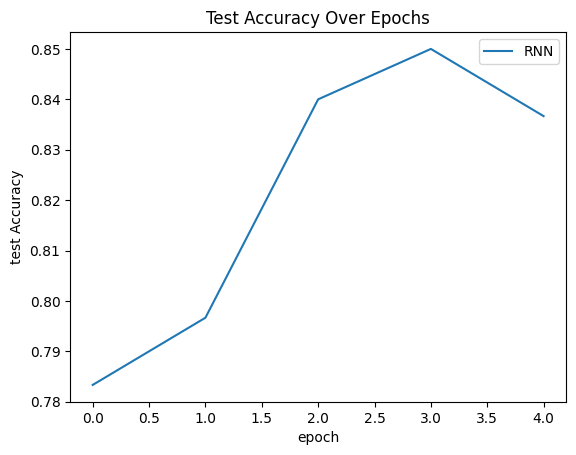

In [37]:
sns.lineplot(x='epoch', y='test Accuracy', data=results_df, label='RNN')
plt.title("Test Accuracy Over Epochs")
plt.show()

In [38]:
pred_rnn = first_rnn.to("cpu").eval()
with torch.inference_mode():
    preds = F.softmax(pred_rnn(dataset.string2InputVec("frank").reshape(1,-1)), dim=-1)
    for class_id in range(len(dataset.label_names)):
        print(dataset.label_names[class_id], ":", preds[0,class_id].item()*100 , "%")

Arabic : 4.1958048939704895 %
Chinese : 3.7734143435955048 %
Czech : 6.915605068206787 %
Dutch : 5.849756672978401 %
English : 5.787361413240433 %
French : 4.937802627682686 %
German : 7.215854525566101 %
Greek : 5.975043028593063 %
Irish : 7.377558946609497 %
Italian : 4.890928417444229 %
Japanese : 6.2878042459487915 %
Korean : 5.514342337846756 %
Polish : 4.458523914217949 %
Portuguese : 5.418014898896217 %
Russian : 4.759784787893295 %
Scottish : 5.732452496886253 %
Spanish : 5.197713524103165 %
Vietnamese : 5.712233856320381 %


### More simple example

In [39]:
import torch
import torch.nn as nn

# Sample data: 3 batches, each with 5 names
names_batch = [
    # Batch 1: 5 American names
    ["John", "Elizabeth", "Michael", "Jennifer", "Christopher"],
    
    # Batch 2: 5 Japanese names
    ["Hiroshi", "Yuki", "Takeshi", "Aiko", "Kenji"],
    
    # Batch 3: 5 Indian names
    ["Raj", "Priya", "Aditya", "Divya", "Vikram"]
]

# Step 1: Convert characters to indices
# First, create a vocabulary of all characters
all_chars = set()
for batch in names_batch:
    for name in batch:
        all_chars.update(name)

char_to_idx = {char: i+1 for i, char in enumerate(sorted(all_chars))}

# Add padding token
char_to_idx['<PAD>'] = 0
idx_to_char = {i: char for char, i in char_to_idx.items()}

print("Character vocabulary size:", len(char_to_idx))
print("Character mapping example:", {k: char_to_idx[k] for k in list(char_to_idx.keys())[:5]})

# Step 2: Find the longest name to determine max sequence length
max_name_length = max(len(name) for batch in names_batch for name in batch)
print("Maximum name length:", max_name_length)

# Step 3: Convert names to padded sequences of indices
# Shape will be [batch_size, seq_length, input_size]
# Where input_size=1 (one character at a time)
input_data = torch.zeros(3, 5, max_name_length, dtype=torch.long)

for batch_idx, batch in enumerate(names_batch):
    for name_idx, name in enumerate(batch):
        for char_idx, char in enumerate(name):
            input_data[batch_idx, name_idx, char_idx] = char_to_idx[char]

print("Input tensor shape:", input_data.shape)
print("\nEncoded first name in batch 1:", input_data[0, 0])
print("Decoded back:", ''.join([idx_to_char[idx.item()] for idx in input_data[0, 0] if idx.item() > 0]))

# Step 4: For RNN processing, we need to convert this to one-hot encoding or embeddings
# Let's use embeddings which is more efficient
vocab_size = len(char_to_idx)
embedding_dim = 10  # Size of character embeddings

class NameRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(NameRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
        # We'll use the final hidden state for classification
        
    def forward(self, x):
        # x shape: [batch_size, seq_length] for each name
        embedded = self.embedding(x)  # Shape: [batch_size, seq_length, embedding_dim]
        output, hidden = self.rnn(embedded)
        return output, hidden

# For processing, we'd need to reshape our data
# Let's process one batch at a time for clarity
model = NameRNN(vocab_size, embedding_dim, hidden_size=20)

# Process the first name in each batch
first_names = input_data[:, 0, :]  # Shape: [3, max_name_length]
output, hidden = model(first_names)

print("\nOutput shape for first names:", output.shape)  # Should be [3, max_name_length, 20]
print("Hidden state shape:", hidden.shape)  # Should be [1, 3, 20]

Character vocabulary size: 36
Character mapping example: {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'H': 5}
Maximum name length: 11
Input tensor shape: torch.Size([3, 5, 11])

Encoded first name in batch 1: tensor([ 6, 27, 20, 26,  0,  0,  0,  0,  0,  0,  0])
Decoded back: John

Output shape for first names: torch.Size([3, 11, 20])
Hidden state shape: torch.Size([1, 3, 20])
